In [1]:
import json

import gc_utils
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import gridspec
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit

In [2]:
sim = "m12m"
sim_dir = "/Users/z5114326/Documents/simulations/"

ghost_file = sim_dir + sim + "/" + sim + "_ghosts.hdf5"
ghost_data = h5py.File(ghost_file, "r")  # open processed data file

# proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
# proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "/snapshot_times_public.txt"
pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
pub_snaps.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]
snp_lst = pub_snaps["index"].values
tim_lst = pub_snaps["time_Gyr"].values

grp_file = sim_dir + sim + "/" + "gc_groups.json"
with open(grp_file, "r") as file:
    grp_dict = json.load(file)

grp_lst = [int(grp) for grp in grp_dict[sim]]

In [3]:
n_lst = []
mass_lst = []
n_surv_lst = []

for it_id in ghost_data.keys():
    src_dat = ghost_data[it_id]["source"]
    mass = 10 ** src_dat["logm_tfor"][()]
    mass_lst.append(np.average(mass))
    # mass_lst.append(np.sum(mass))
    n_lst.append(len(mass))

    snp_dat = ghost_data[it_id]["snapshots"]["snap600"]
    n_surv_lst.append(len(snp_dat["gcid"][()]))

n_lst = np.array(n_lst)
mass_lst = np.array(mass_lst)
n_surv_lst = np.array(n_surv_lst)

Text(0.5, 1.0, 'm12m: All iterations of GC model')

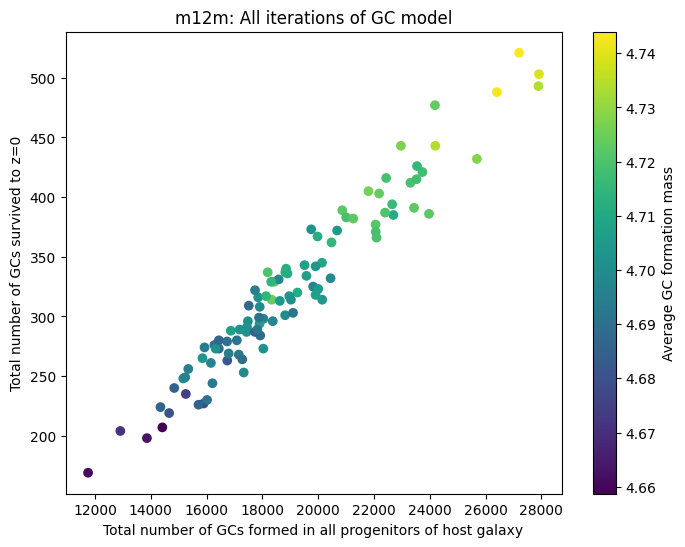

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(n_lst, n_surv_lst, c=np.log10(mass_lst))
plt.colorbar(label="Average GC formation mass")
# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Total number of GCs formed in all progenitors of host galaxy")
plt.ylabel("Total number of GCs survived to z=0")

plt.title(sim + ": All iterations of GC model")

# plt.plot([0, 18000], [0, 350])

In [5]:
def plot_func_1(x, A):
    return A * x


def plot_func_2(x, a, b):
    return a * x + b

0: y = 0.02x, y = 0.02x + -3.743
30145433: y = 0.013x, y = 0.026x + -13.319
37002741: y = 0.015x, y = 0.02x + -23.447
40978260: y = 0.019x, y = 0.04x + -6.117
63550494: y = 0.025x, y = 0.046x + -13.355
76444787: y = 0.014x, y = 0.033x + -9.018


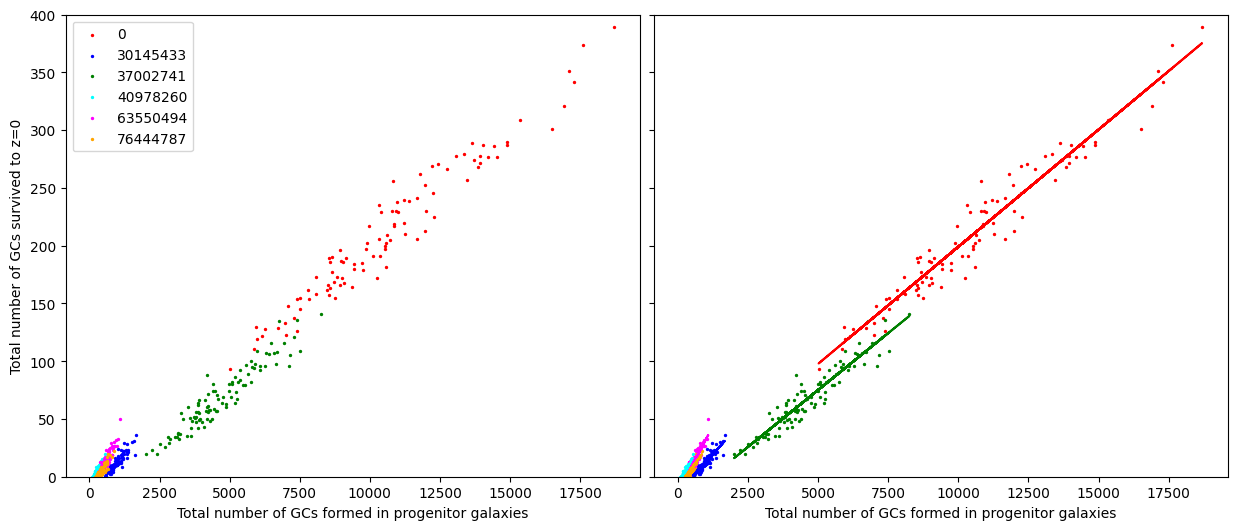

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True)
plt.subplots_adjust(wspace=0.025)

data_dict = {grp: {"all": [], "z0": []} for grp in grp_lst}
for it_id in ghost_data.keys():
    src_dat = ghost_data[it_id]["source"]
    for grp in grp_lst:
        # if grp == 0:
        #     continue
        gmsk = np.abs(src_dat["grpid"][()]) == grp
        smsk = src_dat["s_flag"][()] == 1

        data_dict[grp]["all"].append(np.sum(gmsk))
        data_dict[grp]["z0"].append(np.sum(gmsk & smsk))

for grp in grp_lst:
    x = data_dict[grp]["all"]
    y = data_dict[grp]["z0"]
    c = grp_dict[sim][str(grp)]
    axs[0].scatter(x, y, c=c, s=2, label=grp)
    axs[1].scatter(x, y, c=c, s=2)

    popt1, pcov1 = curve_fit(plot_func_1, x, y)
    y_fit1 = plot_func_1(np.array(x), *popt1)
    # axs[0].plot(x, y_fit1, c=c)

    popt2, pcov2 = curve_fit(plot_func_2, x, y)
    y_fit2 = plot_func_2(np.array(x), *popt2)
    axs[1].plot(x, y_fit2, c=c)

    print(f"{grp}: y = {np.round(popt1[0], 3)}x, y = {np.round(popt2[0], 3)}x + {np.round(popt2[1], 3)}")

for ax in axs:
    ax.set_ylim(0, 400)
    ax.set_xlabel("Total number of GCs formed in progenitor galaxies")

axs[1].set_yticklabels([])
axs[0].legend()
axs[0].set_ylabel("Total number of GCs survived to z=0")

plt.show()

# Each point is an iteration
# Linear relation implies a fixed survival fraction for each accretion event / galaxy
# What impact survival fraction (different galaxies have different survival fraction)
# Each line fit is through origin (0,0)

0: y = 0.02x + -3.743
30145433: y = 0.026x + -13.319
37002741: y = 0.02x + -23.447
40978260: y = 0.04x + -6.117
63550494: y = 0.046x + -13.355
76444787: y = 0.033x + -9.018


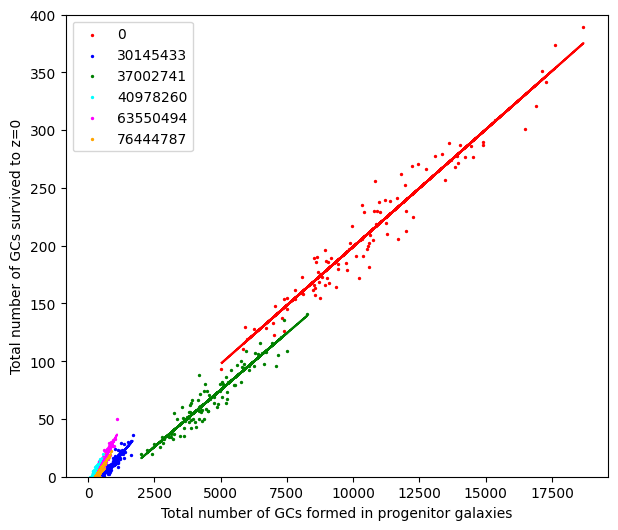

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6), sharex=True)

data_dict = {grp: {"all": [], "z0": []} for grp in grp_lst}
for it_id in ghost_data.keys():
    src_dat = ghost_data[it_id]["source"]
    for grp in grp_lst:
        # if grp == 0:
        #     continue
        gmsk = np.abs(src_dat["grpid"][()]) == grp
        smsk = src_dat["s_flag"][()] == 1

        data_dict[grp]["all"].append(np.sum(gmsk))
        data_dict[grp]["z0"].append(np.sum(gmsk & smsk))

for grp in grp_lst:
    x = data_dict[grp]["all"]
    y = data_dict[grp]["z0"]
    c = grp_dict[sim][str(grp)]
    ax.scatter(x, y, c=c, s=2, label=grp)

    popt2, pcov2 = curve_fit(plot_func_2, x, y)
    y_fit2 = plot_func_2(np.array(x), *popt2)
    ax.plot(x, y_fit2, c=c)

    print(f"{grp}: y = {np.round(popt2[0], 3)}x + {np.round(popt2[1], 3)}")

ax.set_ylim(0, 400)
ax.set_xlabel("Total number of GCs formed in progenitor galaxies")

ax.legend()
ax.set_ylabel("Total number of GCs survived to z=0")

plt.show()

# Each point is an iteration
# Linear relation implies a fixed survival fraction for each accretion event / galaxy
# What impact survival fraction (different galaxies have different survival fraction)
# Each line fit is through origin (0,0)

What about Mass?

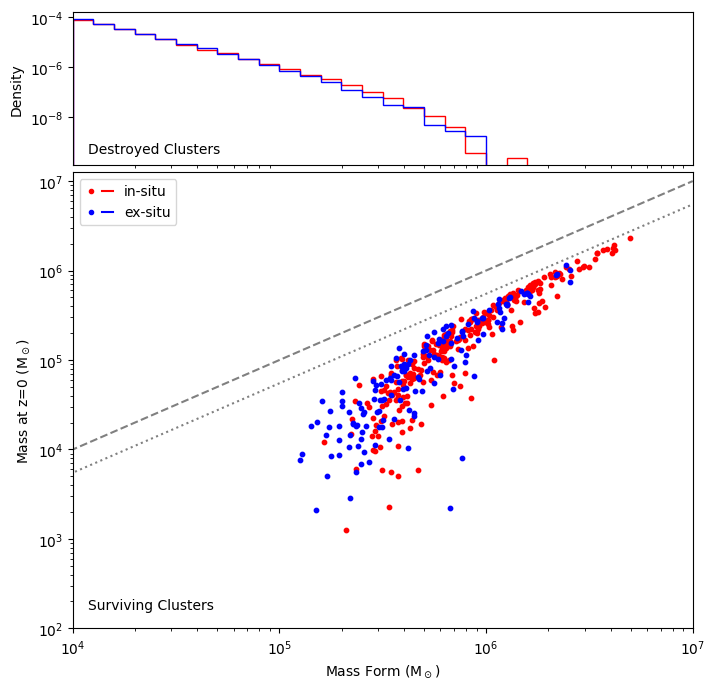

In [8]:
it = 1
it_id = gc_utils.iteration_name(it)

src_dat = ghost_data[it_id]["source"]

m_fo = 10 ** src_dat["logm_tfor"][()]
m_z0 = 10 ** src_dat["logm_tz0"][()]

s_msk = src_dat["s_flag"][()] == 1
grp_msk = src_dat["grpid"][()] == 0

m_fo_in = m_fo[s_msk & grp_msk]
m_z0_in = m_z0[s_msk & grp_msk]

m_fo_ex = m_fo[s_msk & ~grp_msk]
m_z0_ex = m_z0[s_msk & ~grp_msk]

m_fo_in_d = m_fo[~s_msk & grp_msk]
m_fo_ex_d = m_fo[~s_msk & ~grp_msk]

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(hspace=0.025)

bins = bins = np.logspace(4, 7, 31)
ax0.hist(m_fo_in_d, bins=bins, histtype="step", color="r", density=True)
ax0.hist(m_fo_ex_d, bins=bins, histtype="step", color="b", density=True)

ax1.scatter(m_fo_in, m_z0_in, c="r", s=10)
ax1.scatter(m_fo_ex, m_z0_ex, c="b", s=10)

ax0.set_xscale("log")
ax1.set_xscale("log")
ax0.set_yscale("log")
ax1.set_yscale("log")

x_lin = np.array([10**2, 10**7])
y_lin = x_lin

ax1.plot(x_lin, y_lin, c="grey", ls="--")
ax1.plot(x_lin, 0.55 * y_lin, c="grey", ls="dotted")

ax0.set_xlim(10**4, 10**7)
ax1.set_xlim(10**4, 10**7)

ax0.set_xticks([])

ax1.set_ylim(10**2, 10**7.1)

ax1.set_xlabel(r"Mass Form (M$_\odot$)")
ax1.set_ylabel(r"Mass at z=0 (M$_\odot$)")
ax0.set_ylabel(r"Density")

ax0.text(0.025, 0.1, "Destroyed Clusters", transform=ax0.transAxes, ha="left", va="center")
ax1.text(0.025, 0.05, "Surviving Clusters", transform=ax1.transAxes, ha="left", va="center")

indot = plt.Line2D([], [], color="r", marker=".", linestyle="None", markersize=6)
inlin = plt.Line2D([], [], color="r", linestyle="-", lw=1.5)
exdot = plt.Line2D([], [], color="b", marker=".", linestyle="None", markersize=6)
exlin = plt.Line2D([], [], color="b", linestyle="-", lw=1.5)

plt.legend(
    [(indot, inlin), (exdot, exlin)],
    ["in-situ", "ex-situ"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=10,
)


In [9]:
grpid = 0
snap = 600

snap_id = gc_utils.snapshot_name(snap)
snp_dat = ghost_data["it001"]["snapshots"][snap_id]
grpmsk = snp_dat["grpid"][()] == np.abs(grpid)

vel_sph = snp_dat["halo.vel.sph"][grpmsk]
dis_sph = np.std(vel_sph, axis=0)
dis_sph_2 = dis_sph**2
beta = 1 - (np.sum(dis_sph_2[1:]) / (2 * dis_sph_2[0]))
beta


0.2221204726570648

- **β = 0** → isotropic orbits (radial and tangential dispersions equal)
- **β > 0** → radially biased orbits
- **β < 0** → tangentially biased orbits
